# Lab 6
### Morphology

Skimage morphology operators' documentation:
https://scikit-image.org/docs/dev/api/skimage.morphology.html

In [2]:
from commonfunctions import *
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

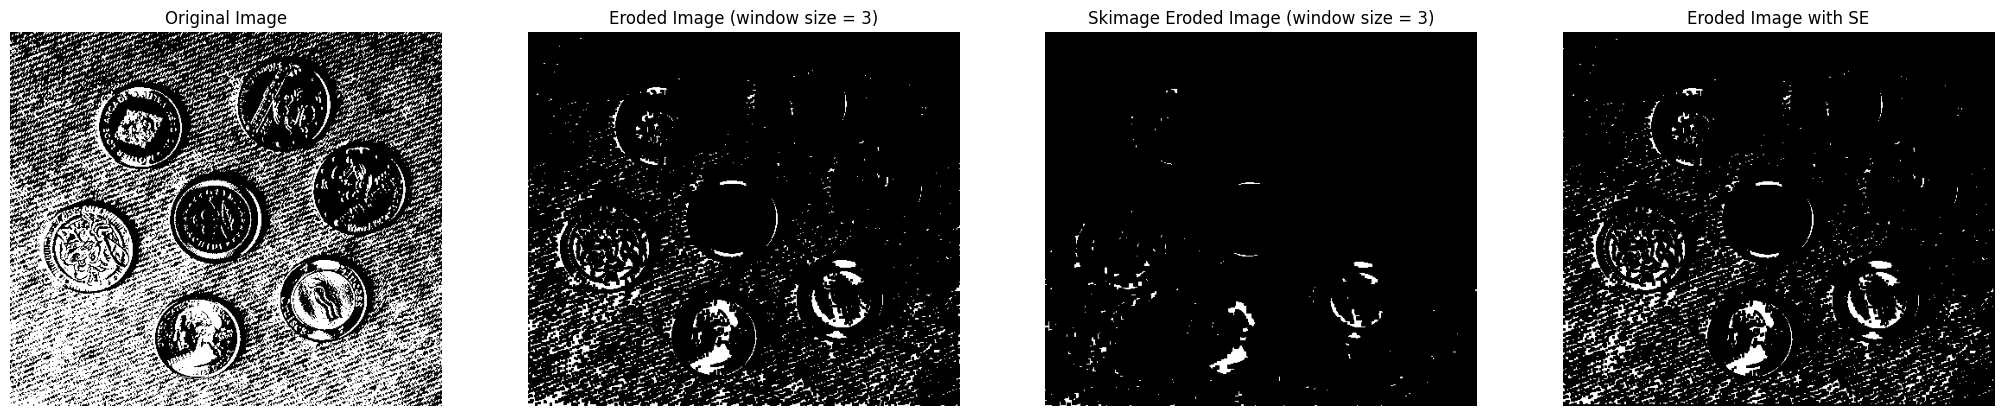

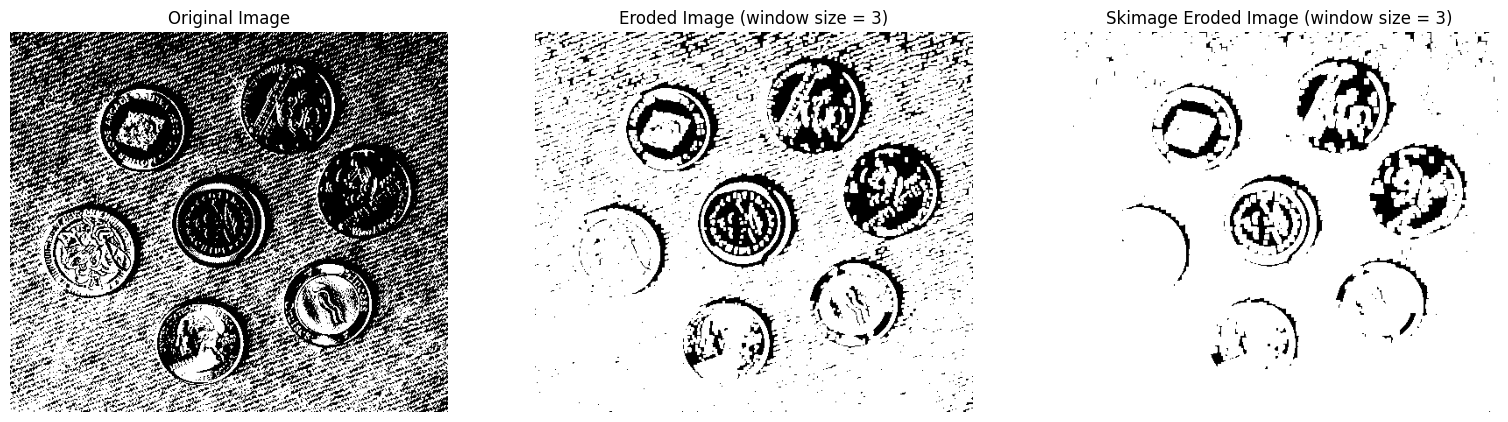

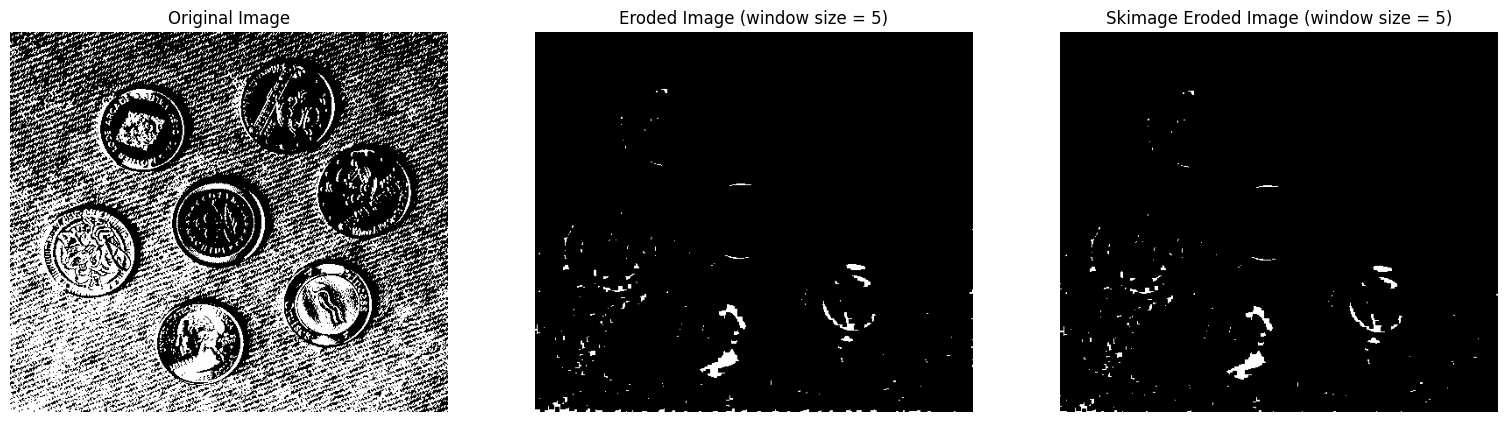

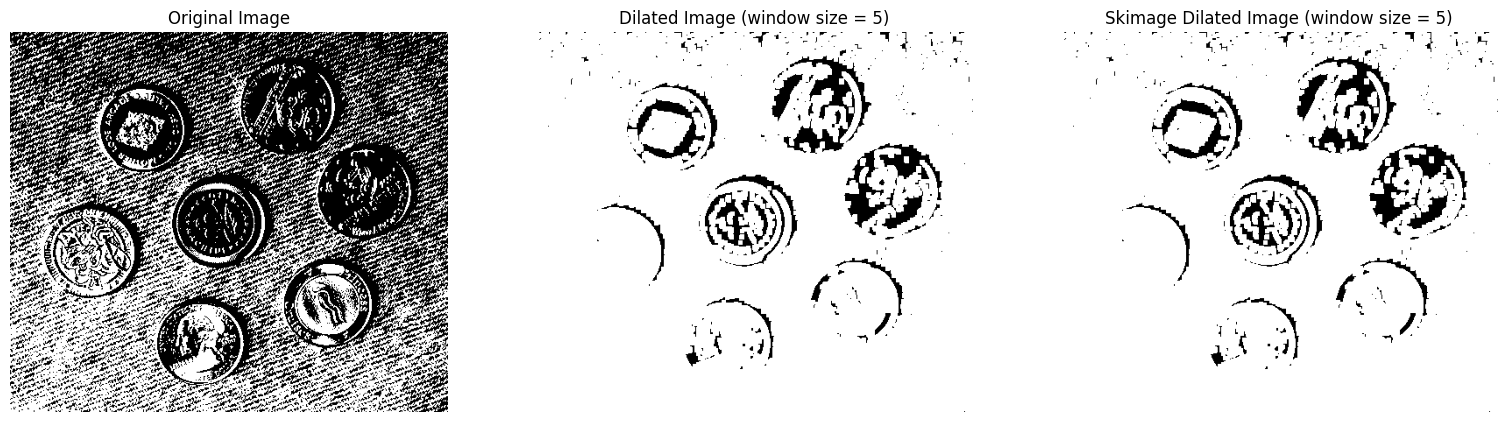

In [13]:
'''
1) Erosion / Dilation:
    - Load "coins.jpg" from the img folder
    - Convert the image to binary
    - Write 2 functions each applying 1 of the erosion/dilation algorithms (with adjustable square window size) manually to the binary image
    - Use Skimage's "binary_erosion" & "binary_dilation" & show the results
'''
from skimage.filters import threshold_otsu

def load_image(img_path,threshold=-1):
    img = io.imread(img_path)
    gray_img = rgb2gray(img) 
    if(threshold == -1):
        threshold = threshold_otsu(gray_img) 
    binary_img = gray_img > threshold
    return binary_img

def erosion_with_fixed_size(binary_img, window_size):
    eroded_img = np.zeros_like(binary_img)
    H, W = binary_img.shape    
    for i in range(H):
        for j in range(W):
            window = binary_img[i:i+window_size, j:j+window_size]
            eroded_img[i, j] = np.min(window)  
    return eroded_img

def erosion(image, se):
    copied_image = image.copy()
    img_h, img_w = image.shape
    se_h, se_w = se.shape
    pad_h = se_h // 2
    dilated_image = np.zeros_like(image)
    padded_image = np.pad(image, pad_h, mode='constant', constant_values=1)
    for i in range(pad_h,img_h-pad_h):
        for j in range(pad_h,img_w-pad_h):
            region = padded_image[i-pad_h:i+pad_h+1, j-pad_h:j+pad_h+1]
            if np.array_equal(region & se,se):
                dilated_image[i-pad_h, j-pad_h] = 1  
            else:
                dilated_image[i, j] = 0
    
    return dilated_image

def dilation_with_fixed_size(binary_img, window_size):
    # Pad the image to handle edges
    pad_size = window_size // 2
    padded_img = np.pad(binary_img, pad_size, mode='constant', constant_values=0)

    dilated_img = np.zeros_like(binary_img)
    H, W = binary_img.shape

    for i in range(H):
        for j in range(W):
            # Extract the region matching the kernel size
            window = padded_img[i:i + window_size, j:j + window_size]
            # Apply dilation: take the maximum value in the window
            dilated_img[i, j] = np.max(window)
    
    return dilated_img


def dilation(image, se):
    copied_image = image.copy()
    dilated_image = np.zeros_like(image)
    img_h, img_w = image.shape
    se_h, se_w = se.shape
    pad_h = se_h // 2
    padded_image = np.pad(image, pad_h, mode='constant', constant_values=1)
    for i in range(pad_h,img_h-pad_h):
        for j in range(pad_h,img_w-pad_h):
            region = padded_image[i-pad_h:i+pad_h+1, j-pad_h:j+pad_h+1]
            if np.any(region & se):
                dilated_image[i-pad_h, j-pad_h] = 1  
            else:
                dilated_image[i, j] = 0
    
    return dilated_image

#read the image
coins_img = load_image("img/coins.jpg")

#apply the erosion and dilation function with different window sizes
window_size = 3
structure_element = np.ones((window_size, window_size), dtype=int)
coins_eroded_3 = erosion_with_fixed_size(coins_img, window_size)
coins_dilated_3 = dilation_with_fixed_size(coins_img, window_size)
coins_eroded_3_se = erosion(coins_img, structure_element)
coins_dilated_3_se = dilation(coins_img, structure_element)

window_size = 5
structure_element = np.ones((window_size, window_size), dtype=int)
coins_eroded_5 = erosion_with_fixed_size(coins_img, window_size)
coins_dilated_5 = dilation_with_fixed_size(coins_img, window_size)

skimage_eroded_image_3 = binary_erosion(coins_img, structure_element)
skimage_dilated_image_3 = binary_dilation(coins_img, structure_element)

skimage_eroded_image_5 = binary_erosion(coins_img, structure_element)
skimage_dilated_image_5 = binary_dilation(coins_img, structure_element)


#plot the results

#erosion with window size = 3
show_images([coins_img, coins_eroded_3, skimage_eroded_image_3, coins_eroded_3_se], ["Original Image", "Eroded Image (window size = 3)",  "Skimage Eroded Image (window size = 3)", "Eroded Image with SE"])

#dilation with window size = 3
show_images([coins_img, coins_dilated_3, skimage_dilated_image_3], ["Original Image", "Eroded Image (window size = 3)",  "Skimage Eroded Image (window size = 3)"])

#erosion with window size = 5
show_images([coins_img, coins_eroded_5, skimage_eroded_image_5], ["Original Image", "Eroded Image (window size = 5)",  "Skimage Eroded Image (window size = 5)"])

#dilation with window size = 3
show_images([coins_img, coins_dilated_5, skimage_dilated_image_5], ["Original Image", "Dilated Image (window size = 5)",  "Skimage Dilated Image (window size = 5)"])


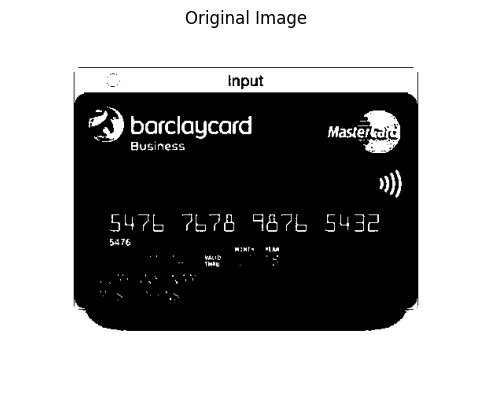

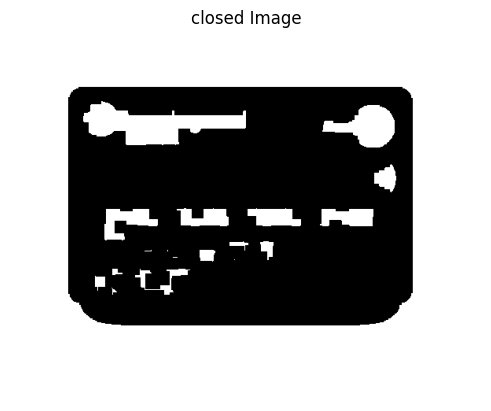

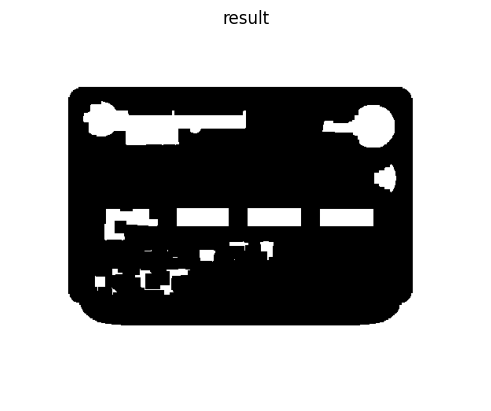

In [42]:
'''
2) Case Study: Credit Card Number Extraction
    - Load "card.jpg" from the img folder
    - Convert the image to binary by brightness thresholding maintaining the card number details for extraction
    - Use your erosion/dilation functions, or Skimage's functions only if you didn't implement them, to apply closing
        Note: The goal of this step is to join the card number into 4 sets of connected pixels
    - Use Skimage's "find_contours" to get the bounding boxes for the credit card's numbers by filtering on aspect ratio (between 2.5 & 3.5)
        Note: When using "find_contours(img, 0.8)" the o/p is a list of contours each having:
                - contour[:,0] being the Y values of the contour perimeter points
                - contour[:,1] being the X values of the contour perimeter points
'''

#read the image and convert it to binary
card_img1 = io.imread("img/card.jpg")
card_img = load_image("img/card.jpg",0.7)
show_images([card_img], ["Original Image"])

sz = 15
se = np.array([
    [0,1,0],
    [1,1,1],
    [0,1,0]])


def closing(img,sz):
    dilated_img = dilation_with_fixed_size(img,sz)
    eroded_img = erosion_with_fixed_size(dilated_img,sz)
    return eroded_img

eroded_card_img = closing(card_img,sz)
show_images([eroded_card_img], ["closed Image"])

contours=find_contours(eroded_card_img,0.8)
bounding_boxes=[]
for contour in contours:
    min_x, max_x = np.min(contour[:, 1]), np.max(contour[:, 1])
    min_y, max_y = np.min(contour[:, 0]), np.max(contour[:, 0])
    W, H = max_x - min_x, max_y - min_y
    aspect_ratio = W / H
    if 2.5 <= aspect_ratio <= 3.5:  
        bounding_boxes.append([min_x,max_x,min_y, max_y])
    
img_with_boxes = eroded_card_img.copy()
for box in bounding_boxes:
    [Xmin, Xmax, Ymin, Ymax] = box
    rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=card_img.shape)
    img_with_boxes[rr, cc] = 1 #set color white

# When provided with the correct format of the list of bounding_boxes, this section will set all pixels inside boxes in img_with_boxes

show_images([img_with_boxes],["result"])

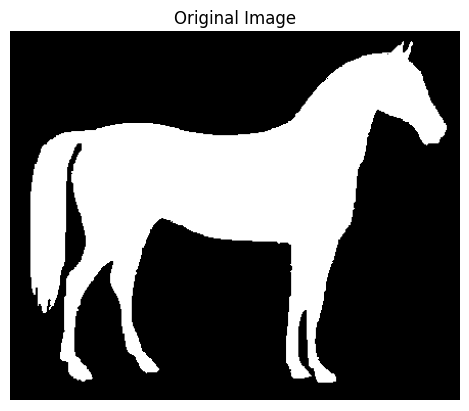

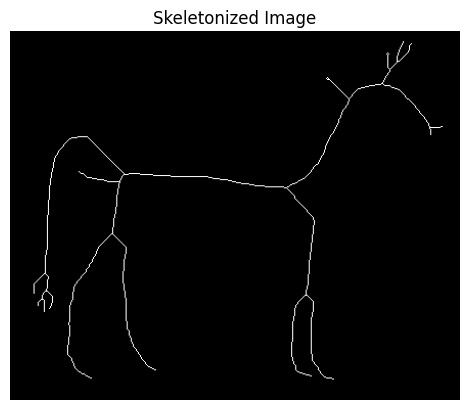

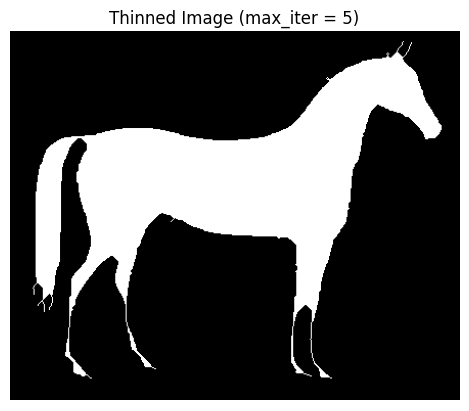

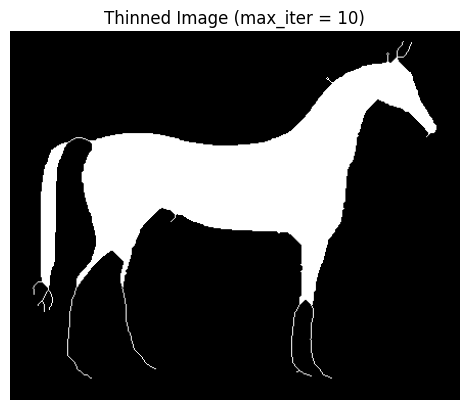

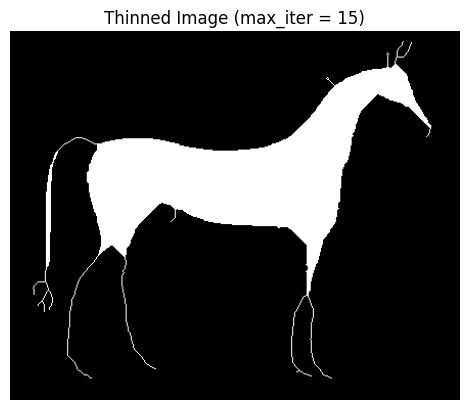

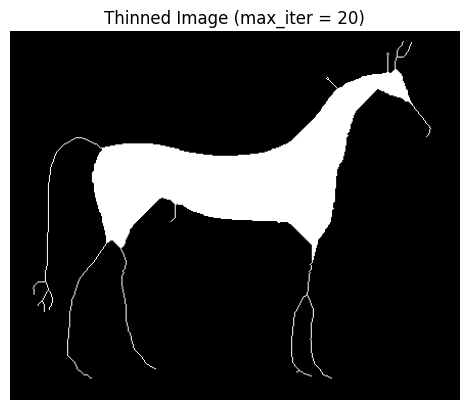

In [5]:
'''
3) Skeletonization:
    - Load "horse.jpg" from the img folder 
    - Use a binary threshold of 0.9 to remove invisible noise in the background
    - Use Skimage's "skeletonize(image)" to acquire the image's skeleton & show it
    - Use Skimage's "thin(image, max_iter)" with values of max_iter 5/10/15/20 & show it
'''

horse_img = load_image("img/horse.jpg",0.9)

skeletonized_horse = horse_img.copy()
show_images([horse_img], ["Original Image"])

skeletonized_horse = horse_img.copy()
skeletonized_horse=skeletonize(skeletonized_horse)
show_images([skeletonized_horse], ["Skeletonized Image"])

thinned_horse = [0]*4
for i in range(4):
    thinned_horse_image = horse_img.copy()
    thinned_horse[i] = thin(thinned_horse_image, max_num_iter=(i+1)*5)
    show_images([thinned_horse[i]], ["Thinned Image (max_iter = "+str((i+1)*5)+")"])

